In [109]:
import typing
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from functools import partial as ftPartial
import numpy as np

e: float = 2.71828

Mějme funkci gaussovského rozpadu: $y = y_0·e^{-k·t}$\
K funkci přidáme "smetí" a to smetí se pokusíme proložit křivkou.


In [110]:
def gaussDecay(xi: float, y0: float, k: float) -> float:
    return y0 * e**(-k*xi)

def chaosMaker(iptArray: np.ndarray, deviationMagPercentage: float = 0.5) -> np.ndarray:
    dmp: float = deviationMagPercentage
    chaosAdded: typing.Sequence[float] = np.array([np.random.uniform(_*(1.0-dmp), _*(1.0+dmp)) for _ in iptArray])
    return chaosAdded   

def chaosFunctionVectorized(npFunction: typing.Callable[[np.ndarray], np.ndarray], iptNumbers: np.ndarray, deviationMagPercentage: float = 0.5) -> np.ndarray:
    baseValues  = npFunction(iptNumbers)
    chaosValues = chaosMaker(baseValues, deviationMagPercentage=deviationMagPercentage)
    return chaosValues

y0: float   = 1.26
k: float    = 0.16
gaussDecayVectorized: typing.Callable[[np.ndarray, float, float], np.ndarray] = np.vectorize(gaussDecay)


gaussDecaySingleIPT: typing.Callable[[float], float] = ftPartial(gaussDecay, y0=y0, k=k)
gaussDecaySingleIPTVectorized: typing.Callable[[np.ndarray], np.ndarray] = np.vectorize(pyfunc=gaussDecaySingleIPT)

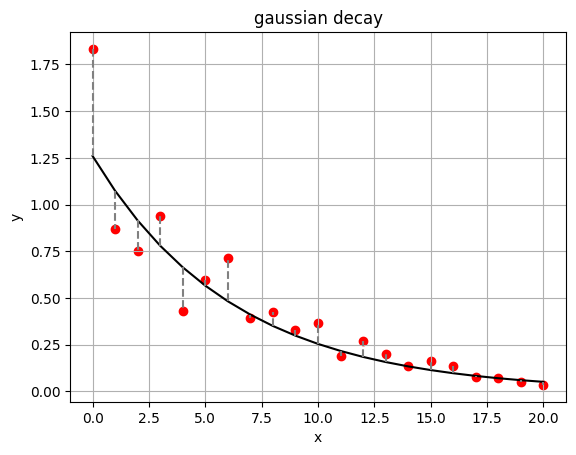

In [111]:
x:          typing.Sequence[float] = np.linspace(0.0, 20.0, 21)
y_pure:     typing.Sequence[float] = gaussDecaySingleIPTVectorized(x)
y_chaos:    typing.Sequence[float] = chaosFunctionVectorized(npFunction= gaussDecaySingleIPTVectorized, iptNumbers=x)

plt.plot(x, y_pure, color="black", label="function")
plt.scatter(x, y_chaos, c="red", label="chaos")
plt.grid()
plt.xlabel("x"), plt.ylabel("y"), plt.title("gaussian decay")

for x,y1,y2 in zip(x,y_pure, y_chaos):
    plt.plot([x,x], [y1,y2], color="gray", linestyle="dashed")

plt.show()



Metoda nejmenších čtverců iterativně minimalizuje hodnotu sumy čtverců reziduí \
$\lim_{n->\inf}{\sum{(f(x_i)_{křivka}-f(x_i)_{měření})^2}} = 0 $\

Proč se používají čtverce a ne absolutní hodnoty?
- pozice minima je stejná jako u absolutní hodnoty
- narozdíl od absolutní hodnoty lineární funkce je funkce spojitá, jemná, její derivace existuje všude.

In [112]:
def squareDiffResidual(curveValue: float, measurementValue: float) -> float:
    return (measurementValue-curveValue)**2

squareDiffResidualVectorized: typing.Callable[[np.ndarray, np.ndarray], np.ndarray] = np.vectorize(squareDiffResidual)

def sumSquareDiffResidualVectorized(dependentValuesCurve: np.ndarray, dependentValuesMeasurement: np.ndarray) -> float:
    return np.sum(squareDiffResidualVectorized(dependentValuesCurve, dependentValuesMeasurement))

def leastSquareMethod(
    vectorizedFunction: typing.Callable[[np.ndarray, float, float], np.ndarray],
    indepependentValuesMeasurement: np.ndarray,
    dependentValuesMeasurement: np.ndarray,
    x0: float,
    x1: float,
    iterations: typing.Optional[int] = 1000) -> typing.Sequence[float]:

    def plotter(coeffList: typing.Sequence[float], SSRDlist: typing.Sequence[float], coefficient: float) -> None:
        plt.text(x= 0.5*sum((min(coeffList), max(coeffList))),
            y= 0.5*sum((min(SSRDlist), max(SSRDlist))),
            s=f"{coefficient}"
            )
        plt.plot(coeffList, SSRDlist)
        plt.grid()
        plt.xlabel("x0"), plt.ylabel("SSRD")
        plt.show()
    
    def coeffGetter(c0: float, c1: float, coef_position: int, delta: float = 0.005):
        nonlocal iterations, indepependentValuesMeasurement
        calculatedFx: np.ndarray    = vectorizedFunction(indepependentValuesMeasurement, x0, x1)
        curIter: int                = 0
        coefficients: list[float]   = []
        sums: list[float]           = []
        
        while curIter < iterations:
            SSRD = sumSquareDiffResidualVectorized(calculatedFx, dependentValuesMeasurement)
            sums.append(SSRD)
            
            if curIter % 100 == 0: print(curIter, (c0, c1), SSRD)
            
            if      coef_position == 0: c0 += delta
            elif    coef_position == 1: c1 += delta
            
            calculatedFx = vectorizedFunction(indepependentValuesMeasurement, c0, c1)
            
            if      coef_position == 0: coefficients.append(c0)
            elif    coef_position == 1: coefficients.append(c1)
            curIter += 1
        
        lowestSumIndex:int = sums.index(min(sums))
        coefficient        = coefficients[lowestSumIndex]
        plotter(coeffList=coefficients, SSRDlist=sums, coefficient=coefficient)
        return coefficient

    x0: float = coeffGetter(c0=x0, c1=x1, coef_position=0, delta=0.005)
    x1: float = coeffGetter(c0=x0, c1=x1, coef_position=1, delta=0.001)
    return x0, x1

0 (0.5, 0.1) 6.3020877525398245
100 (1.0000000000000004, 0.1) 5.3752319209231345
200 (1.4999999999999898, 0.1) 4.640690815081566
300 (1.9999999999999791, 0.1) 4.098464435015093
400 (2.4999999999999685, 0.1) 3.7485527807237164
500 (2.999999999999958, 0.1) 3.590955852207437
600 (3.499999999999947, 0.1) 3.625673649466254
700 (3.9999999999999365, 0.1) 3.8527061725001683
800 (4.499999999999926, 0.1) 4.272053421309178
900 (4.999999999999916, 0.1) 4.883715395893285
1000 (5.499999999999905, 0.1) 5.687692096252489
1100 (5.999999999999894, 0.1) 6.683983522386789
1200 (6.499999999999884, 0.1) 7.872589674296186
1300 (6.999999999999873, 0.1) 9.253510551980677
1400 (7.499999999999862, 0.1) 10.826746155440269
1500 (7.999999999999852, 0.1) 12.592296484674955
1600 (8.499999999999929, 0.1) 14.550161539685098
1700 (9.000000000000007, 0.1) 16.700341320470415
1800 (9.500000000000085, 0.1) 19.042835827030892
1900 (10.000000000000163, 0.1) 21.577645059366528


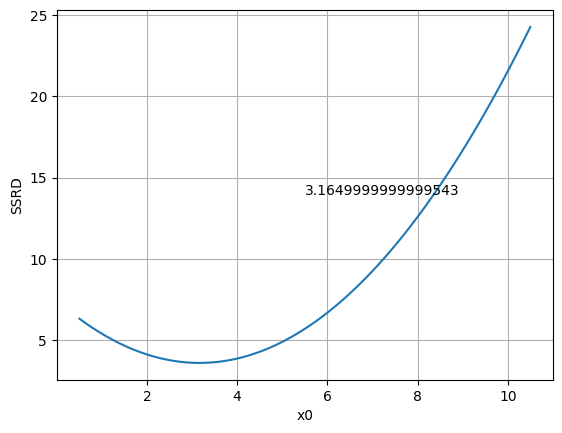

0 (3.1649999999999543, 0.1) 3.58115233236841
100 (3.1649999999999543, 0.2000000000000001) 6.450687969264069
200 (3.1649999999999543, 0.30000000000000016) 7.281647767028434
300 (3.1649999999999543, 0.40000000000000024) 7.402212802031717
400 (3.1649999999999543, 0.5000000000000003) 7.418678007008094
500 (3.1649999999999543, 0.6000000000000004) 7.420909052695802
600 (3.1649999999999543, 0.7000000000000005) 7.421211042111777
700 (3.1649999999999543, 0.8000000000000006) 7.421251912902204
800 (3.1649999999999543, 0.9000000000000007) 7.4212574441863515
900 (3.1649999999999543, 1.0000000000000007) 7.421258192765573
1000 (3.1649999999999543, 1.0999999999999897) 7.421258294074896
1100 (3.1649999999999543, 1.1999999999999786) 7.42125830778564
1200 (3.1649999999999543, 1.2999999999999676) 7.42125830964119
1300 (3.1649999999999543, 1.3999999999999566) 7.421258309892312
1400 (3.1649999999999543, 1.4999999999999456) 7.421258309926297
1500 (3.1649999999999543, 1.5999999999999346) 7.421258309930896
160

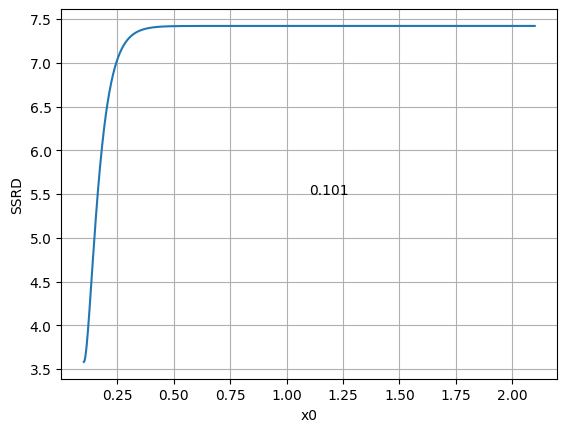

3.1649999999999543 0.101


In [113]:
y0_start    = 0.5
k_start     = 0.1
y0_LSM, k_LSM = leastSquareMethod(vectorizedFunction=gaussDecayVectorized,
                                  indepependentValuesMeasurement=x,
                                  dependentValuesMeasurement=y_chaos,
                                  x0=y0_start,
                                  x1=k_start,
                                  iterations=2000)
x = np.linspace(0.0, 20.0, 21)
print(y0_LSM, k_LSM)
y_LSM: np.ndarray = gaussDecayVectorized(x, y0_LSM, k_LSM)


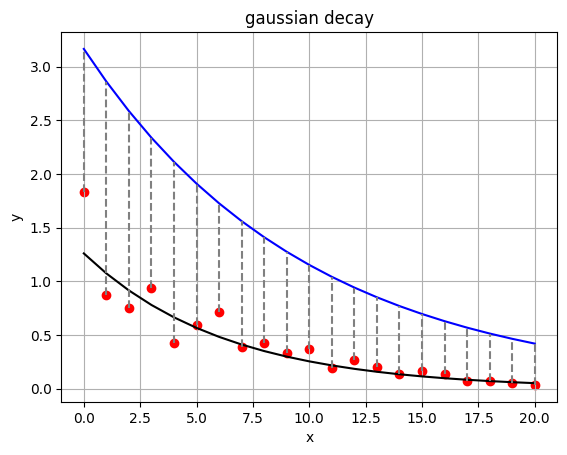

In [114]:
plt.plot(x, y_pure, color="black", label="function")
plt.plot(x, y_LSM, color="blue", label="function")
plt.scatter(x, y_chaos, c="red", label="chaos")
plt.grid()
plt.xlabel("x"), plt.ylabel("y"), plt.title("gaussian decay")

for x,y1,y2 in zip(x,y_chaos, y_LSM):
    plt.plot([x,x], [y1,y2], color="gray", linestyle="dashed")

plt.show()